# Data Analysis: Titanic Data Set

> Udacity Data Analyst Nanodegree: _Project 2_
>
> Author: _Ke Zhang_
>
> Submission Date: _2017-03-30_ (Revision 1)

## Abstract

The [Titanic Data](https://d17h27t6h515a5.cloudfront.net/topher/2016/September/57e9a84c_titanic-data/titanic-data.csv) contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. You can view a description of this dataset on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.

## Content

- [Prepare and preview data](#Prepare-and-preview-data)
- [Define questions](#Define-questions)
- [Wrangle data](#Wrangle-data)
- [Answers](#Answers)
- [Conclusion](#Conclusion)
- [References](#References)

### Prepare and preview data

**Summary of the quick exploration**:

* There are 891 entries (passengers) in the data set. Overall 342 (about 38%) of them survived.
* The data columns 'Cabin', 'Age' and 'Embarked' contain null values.
* The passengers' 'Age' varies from 0.42 to 80 years with a median age of 28.
* In average female passengers paid higher 'Fare' than male passengers.
* In the statistics grouped by 'Pclass' we can see that 'Pclass' and 'Fare' may strongly correlated.

**First "suspicious" findings**:
* The passengers of upper class had a higher mean survival rate. 
    * --> The socio-economic status may have an effect on the survival chance.
* The mean age is smaller in the survived group than in the not-survived group. But the medians are the same in both groups. 
    * --> Small babies may have more likely survived.
    * --> Senior passengers may have less chance to survive.
* The mean number of parents/children aboard is greater in the survived group.
    * --> Children with parents may have greater chance to survive.
* The mean and median of 'Fare' in the survived group are much higher.
    * --> Passengers with higher paid fare e.g. in upper class cabins may have easier access to life boats.
* While only about 20% of the male passengers survived about 75% of female passengers survived. 
    * --> Passenger's gender may have a great influence on the survival rate.

In [1]:
# import libs used in this project
import math
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# initialize plot context and global configurations
%matplotlib inline
sns.set(style='white', palette='muted', color_codes=True)
sns.set_context('notebook', font_scale=1.2, rc={'lines.linewidth': 1.2})
# disable chained assignment warning
pd.options.mode.chained_assignment = None

# color constants
color_survived = '#FCFF77' #yellow
color_died = '#FF6060' #red


In [2]:
# read csv data
df = pd.read_csv('./titanic-data.csv')

# print head entries
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
# display column types and detect possible null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [4]:
col_check_values = [
    'Survived', 
    'Pclass', 
    'Sex',
    'SibSp', 
    'Parch'
]

# print unique values in selected columns
for col_name in df:
    if col_name in col_check_values:
        unique_values = df[col_name].unique()
        unique_values.sort()
        print("Unique values in '{0}': {1}".format(
            col_name,
            unique_values
        ))

Unique values in 'Survived': [0 1]
Unique values in 'Pclass': [1 2 3]
Unique values in 'Sex': ['female' 'male']
Unique values in 'SibSp': [0 1 2 3 4 5 8]
Unique values in 'Parch': [0 1 2 3 4 5 6]


**Variable Descriptions** ([source](https://www.kaggle.com/c/titanic/data))

| Variable | Definition | Notes | dtype | Has NaN? |
|----------|------------|-------|-------|----------|
| PassengerId | Passenger id | | int64 | no |
| Survived | Survival status:<br/>- 0 = No<br/>- 1 = Yes) | | int64 | no |
| Pclass | Ticket class:<br/>- 1 = 1st<br/>- 2 = 2nd<br/>- 3 = 3rd | A proxy for socio-economic status (SES): <br/>- 1st = Upper<br/>- 2nd = Middle<br/>- 3rd = Lower | int64 | no |
| Name | Name | | object | no |
| Sex |	Sex<br/>- female<br/>- male | | object | no |
| Age |	Age in years | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5| float64 | yes |
| Sibsp | # of siblings / spouses aboard<br/>- Data range: 0 to 8 | The dataset defines family relations in this way... <br/>- Sibling = brother, sister, stepbrother, stepsister<br/>- Spouse = husband, wife (mistresses and fiancés were ignored) | int64 | no |
| Parch |	# of parents / children aboard<br/>- Data range: 0 to 6 | The dataset defines family relations in this way...<br/>- Parent = mother, father<br/>- Child = daughter, son, stepdaughter, stepson<br/>- Some children travelled only with a nanny, therefore parch=0 for them.| int64 | no |
| Ticket |	Ticket number | | object | no |
| Fare |	Passenger fare | | float64 | no |
| Cabin |	Cabin number | | object | yes |
| Embarked | Port of Embarkation<br/>- C = Cherbourg<br/>- Q = Queenstown<br/>- S = Southampton) | | object | yes |

In [5]:
col_check_stats = [
    'Survived', 
    'Pclass', 
    'Sex',
    'SibSp', 
    'Parch',
    'Fare'
]

# descriptive statistics on survived passengers
df[df['Survived'] == 1][col_check_stats].describe()

,Survived,Pclass,SibSp,Parch,Fare
count,342.0,342.000000,342.000000,342.000000,342.000000
mean,1.0,1.950292,0.473684,0.464912,48.395408
std,0.0,0.863321,0.708688,0.771712,66.596998
min,1.0,1.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,0.000000,12.475000
50%,1.0,2.000000,0.000000,0.000000,26.000000
75%,1.0,3.000000,1.000000,1.000000,57.000000
max,1.0,3.000000,4.000000,5.000000,512.329200


In [6]:
# descriptive statistics on passengers not survived
df[df['Survived'] == 0][col_check_stats].describe()

,Survived,Pclass,SibSp,Parch,Fare
count,549.0,549.000000,549.000000,549.000000,549.000000
mean,0.0,2.531876,0.553734,0.329690,22.117887
std,0.0,0.735805,1.288399,0.823166,31.388207
min,0.0,1.000000,0.000000,0.000000,0.000000
25%,0.0,2.000000,0.000000,0.000000,7.854200
50%,0.0,3.000000,0.000000,0.000000,10.500000
75%,0.0,3.000000,1.000000,0.000000,26.000000
max,0.0,3.000000,8.000000,6.000000,263.000000


In [7]:
col_check_stats_by_pclass = [
    'Survived',
    'Age', 
    'SibSp', 
    'Parch', 
    'Fare'
]

# statistics by social class
df.groupby(['Pclass'])[col_check_stats_by_pclass].describe()

Survived         Age       SibSp       Parch        Fare
Pclass                                                                  
1      count  216.000000  186.000000  216.000000  216.000000  216.000000
       mean     0.629630   38.233441    0.416667    0.356481   84.154687
       std      0.484026   14.802856    0.611898    0.693997   78.380373
       min      0.000000    0.920000    0.000000    0.000000    0.000000
       25%      0.000000   27.000000    0.000000    0.000000   30.923950
       50%      1.000000   37.000000    0.000000    0.000000   60.287500
       75%      1.000000   49.000000    1.000000    0.000000   93.500000
       max      1.000000   80.000000    3.000000    4.000000  512.329200
2      count  184.000000  173.000000  184.000000  184.000000  184.000000
       mean     0.472826   29.877630    0.402174    0.380435   20.662183
       std      0.500623   14.001077    0.601633    0.690963   13.417399
       min      0.000000    0.670000    0.000000    0.000000    0.000000
       25%      0.000000   23.000000    0.000000    0.000000   13.000000
       50%      0.000000   29.000000    0.000000    0.000000   14.250000
       75%      1.000000   36.000000    1.000000    1.000000   26.000000
       max      1.000000   70.000000    3.000000    3.000000   73.500000
3      count  491.000000  355.000000  491.000000  491.000000  491.000000
       mean     0.242363   25.140620    0.615071    0.393075   13.675550
       std      0.428949   12.495398    1.374883    0.888861   11.778142
       min      0.000000    0.420000    0.000000    0.000000    0.000000
       25%      0.000000   18.000000    0.000000    0.000000    7.750000
       50%      0.000000   24.000000    0.000000    0.000000    8.050000
       75%      0.000000   32.000000    1.000000    0.000000   15.500000
       max      1.000000   74.000000    8.000000    6.000000   69.550000

In [8]:
# passenger with the highest fare
df.loc[df['Fare'].idxmax()]

PassengerId                 259
Survived                      1
Pclass                        1
Name           Ward, Miss. Anna
Sex                      female
Age                          35
SibSp                         0
Parch                         0
Ticket                 PC 17755
Fare                    512.329
Cabin                       NaN
Embarked                      C
Name: 258, dtype: object

In [9]:
# passenger with the highest age
df.loc[df['Age'].idxmax()]

PassengerId                                     631
Survived                                          1
Pclass                                            1
Name           Barkworth, Mr. Algernon Henry Wilson
Sex                                            male
Age                                              80
SibSp                                             0
Parch                                             0
Ticket                                        27042
Fare                                             30
Cabin                                           A23
Embarked                                          S
Name: 630, dtype: object

In [10]:
# all new born babies survived
df[df['Age'] < 1.0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


In [11]:
# only 1 of the elderly passengers older than 65 years survived
df[df['Age'] > 64.0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S


In [12]:
# stats on all female passengers
df[df['Sex'] == 'female'].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,314.000000,314.000000,314.000000,261.000000,314.000000,314.000000,314.000000
mean,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
std,256.846324,0.438211,0.857290,14.110146,1.156520,1.022846,57.997698
min,2.000000,0.000000,1.000000,0.750000,0.000000,0.000000,6.750000
25%,231.750000,0.000000,1.000000,18.000000,0.000000,0.000000,12.071875
50%,414.500000,1.000000,2.000000,27.000000,0.000000,0.000000,23.000000
75%,641.250000,1.000000,3.000000,37.000000,1.000000,1.000000,55.000000
max,889.000000,1.000000,3.000000,63.000000,8.000000,6.000000,512.329200


In [13]:
# stats on all male passengers
df[df['Sex'] == 'male'].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,577.000000,577.000000,577.000000,453.000000,577.000000,577.000000,577.000000
mean,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893
std,257.486139,0.391775,0.813580,14.678201,1.061811,0.612294,43.138263
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,464.000000,0.000000,3.000000,29.000000,0.000000,0.000000,10.500000
75%,680.000000,0.000000,3.000000,39.000000,0.000000,0.000000,26.550000
max,891.000000,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200


### Define questions

These are the questions that we'll answer:

* **Question 1**: What factors made people more likely to survive? Which ones are the strongest?
* **Question 2**: Were passengers in certain age groups more likely to survive? 
* **Question 3**: Did passengers with a higher socio-economic status have a greater chance to survive?
* **Question 4**: Did the passenger's sex have any effects on the survival rate?
* **Question 5**: Could the gender effect also observed among different ticket classes, age groups or person classes?

### Wrangle data

**Summary of the wrangle phase**:
* Check for duplicate entries:
> no duplicated entries found
* Remove unused columns:
> dropped columns: 'Name', 'Ticket', 'Cabin' and 'Embarked'
* Check and fix missing entries:
> columns 'Cabin' and 'Embarked' containing null values were already dropped
>
> column 'Age' contains 177 null values
>
> Since 'Age' is one of our subjects of analysis and no replacement value could be derived from other columns --> dropped all entries in 'Age' containing null values. 
* Add helper columns necessary for the following analysis
> created column 'IsMale': scalar value of 'Sex' (1: male, 0: female)
>
> created column 'SurvivedType': category values for 'Survived': survived or died
>
> created column 'AgeCategory': category values for 'Age' ranges: children, adolescents, adults or seniors
>
> created column 'PersonClass': category values for 'Age' and 'Sex': children, male adults, female adults or seniors
* Change data types of scalar columns
> changed data type of 'Sex' from object to category
* Reorder columns
> set column order to: 'PassengerId', 'Survived', 'SurvivedType', 'Pclass', 'Sex', 'IsMale', 'Age', 'AgeCategory', 'PersonClass', 'SibSp', 'Parch', 'Fare'

In [14]:
# check for duplicate entries
df['PassengerId'].duplicated().sum()

0

In [15]:
# remove unused columns
df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


In [16]:
# check missing values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64

In [17]:
# check entries with 'Age'=NaN for possible replacement values
df[df['Age'].isnull()].head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
5,6,0,3,male,NaN,0,0,8.4583
17,18,1,2,male,NaN,0,0,13.0000
19,20,1,3,female,NaN,0,0,7.2250
26,27,0,3,male,NaN,0,0,7.2250
28,29,1,3,female,NaN,0,0,7.8792


In [18]:
# check NaN entries statistics before drop
df[df['Age'].isnull()].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,177.000000,177.000000,177.000000,0.0,177.000000,177.000000,177.000000
mean,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567
std,250.552901,0.456787,0.763216,NaN,1.626316,0.534145,31.874608
min,6.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000
25%,230.000000,0.000000,3.000000,NaN,0.000000,0.000000,7.750000
50%,452.000000,0.000000,3.000000,NaN,0.000000,0.000000,8.050000
75%,634.000000,1.000000,3.000000,NaN,0.000000,0.000000,24.150000
max,889.000000,1.000000,3.000000,NaN,8.000000,2.000000,227.525000


In [19]:
# drop entries with null values
df = df.dropna(axis=0)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


In [20]:
# create new column 'IsMale' as scalar value for 'Sex'
df['IsMale'] = df['Sex'].map(lambda s: s == 'male').astype(int)
df['IsMale'].describe()

count    714.000000
mean       0.634454
std        0.481921
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: IsMale, dtype: float64

In [21]:
# create new column 'SurvivedType' as category value for 'Survived'
def get_survived_name(survived):
    """
    returns survived status as text
    """
    if survived:
        return 'survived'
    else:
        return 'died'

df['SurvivedType'] = df['Survived'].map(
    get_survived_name
).astype('category')
df['SurvivedType'].describe()

count      714
unique       2
top       died
freq       424
Name: SurvivedType, dtype: object

In [22]:
def get_age_category(age):
    """
    create age category column by Age: 
    - children, 
    - adolescents, 
    - adults and 
    - seniors
    reference: http://www.statcan.gc.ca/eng/concepts/definitions/age2
    """
    if age < 14:
        return 'children'
    elif age < 24:
        return 'adolescents'
    elif age < 64:
        return 'adults'
    else:
        return 'seniors'
    
df['AgeCategory'] = df['Age'].map(
    get_age_category
).astype('category')
df['AgeCategory'].describe()

count        714
unique         4
top       adults
freq         454
Name: AgeCategory, dtype: object

In [23]:
def get_person_class(entry):
    """
    create person class column by Age and Sex: 
    - children,
    - male adults
    - female adults and
    - seniors
    """
    if entry['Age'] < 14:
        return 'children'
    elif entry['Age'] >= 64:
        return 'seniors'
    elif entry['Sex'] == 'male':
        return 'male adults'
    else:
        return 'female adults'
df['PersonClass'] = df.apply(
    get_person_class, 
    axis=1
).astype('category')
df['PersonClass'].describe()

count             714
unique              4
top       male adults
freq              403
Name: PersonClass, dtype: object

In [24]:
# change data types of Sex
df["Sex"] = df["Sex"].astype('category')
# list all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 12 columns):
PassengerId     714 non-null int64
Survived        714 non-null int64
Pclass          714 non-null int64
Sex             714 non-null category
Age             714 non-null float64
SibSp           714 non-null int64
Parch           714 non-null int64
Fare            714 non-null float64
IsMale          714 non-null int32
SurvivedType    714 non-null category
AgeCategory     714 non-null category
PersonClass     714 non-null category
dtypes: category(4), float64(2), int32(1), int64(5)
memory usage: 50.2 KB


In [25]:
# reorder columns
df = df[['PassengerId', 'Survived', 'SurvivedType', 'Pclass', 'Sex', 'IsMale', 'Age', 'AgeCategory', 'PersonClass', 'SibSp', 'Parch', 'Fare']]
df.head()

,PassengerId,Survived,SurvivedType,Pclass,Sex,IsMale,Age,AgeCategory,PersonClass,SibSp,Parch,Fare
0,1,0,died,3,male,1,22.0,adolescents,male adults,1,0,7.2500
1,2,1,survived,1,female,0,38.0,adults,female adults,1,0,71.2833
2,3,1,survived,3,female,0,26.0,adults,female adults,0,0,7.9250
3,4,1,survived,1,female,0,35.0,adults,female adults,1,0,53.1000
4,5,0,died,3,male,1,35.0,adults,male adults,0,0,8.0500


### Answers

In [26]:
"""
common functions used in the data analysis
"""


def print_relative_survival_means(df=df):
    """
    displays the relative difference in means in percent of
    all numerical features defined in the given dataframe
    between survived and died groups.
    """
    # display survived passengers statistics
    mean_survived = df[df['Survived'] == 1].describe().loc['mean']
    mean_died = df[df['Survived'] == 0].describe().loc['mean']
    mean_diff_pct = (mean_survived - mean_died) / mean_survived * 100.0
    print("Relative difference in means of 'Survived' to " +
          "'Died' passenger group in [%]:\n" +
          "(Note: 0.0 --> no difference)\n{0}".format(
              mean_diff_pct
          ))


def plot_corrcoef(df=df):
    """
    plots pearson correlation heatmap of the dataframe
    """
    sns.FacetGrid(df, size=7).map_dataframe(
        lambda data,
        color: sns.heatmap(
            data.corr().abs(),
            linewidths=1,
            cmap="YlGnBu"
        )
    )
    sns.plt.title("Pearson Correlation Matrix")


def print_top_correlations(name='Survived', top=5, df=df):
    """
    displays the strongest correlations to the given
    feature name. (default: 5)
    """
    # calculates pearson correlations for the given feature
    corr = df.corr().loc[name]
    # sort absolute correlations from the strongest
    sorted_corr = corr.abs().sort_values(
        ascending=False
    )[1: 1 + top]
    print("Top {0} correlations between '{1}' and ...:\n{2}\n".format(
        top,
        name,
        sorted_corr
    ))


def print_feature_correlation(name, df=df):
    """
    calculates correlation with Survived and effect size for the given feature
    """
    # print survival statistics
    if df[name].dtype.name != 'category':
        corr = df[name].corr(df['Survived'])
        print("Correlation between '{0}' and '{1}': {2:.2f}".format(
            name,
            'Survived',
            corr
        ))
    check_dependency(name, 'Survived', 0.001, df)


def print_feature_statistics(name, order=None, df=df):
    """
    displays descriptive and survival statistics of the
    given categorical feature.
    """
    # print feature statistics
    print("Descriptive statistics of '{0}':\n{1}\n".format(
        name,
        df[name].describe()
    ))
    abs_distribution = df[name].value_counts(sort=True)
    rel_distribution = abs_distribution / df[name].count()
    if order is not None:
        rel_distribution = rel_distribution[order]
    print("Relative frequencies of '{0}':\n{1}\n".format(
        name,
        rel_distribution
    ))
    abs_survived = df.groupby(name)['Survived'].agg(sum)
    rel_survived = abs_survived / df.groupby(name)['PassengerId'].count()
    if order is not None:
        rel_survived = rel_survived[order]
    print("Survival rate of '{0}':\n{1}".format(
        name,
        rel_survived
    ))


def plot_bivariate_continous(name1, name2, order=None, df=df):
    """
    plots boxplot of the two features by survived type.
    """
    sns.factorplot(
        x=name1,
        y=name2,
        kind='box',
        hue='SurvivedType',
        data=df,
        size=5,
        order=order,
        hue_order=['survived', 'died'],
        palette={'survived': color_survived, 'died': color_died}
    )
    sns.plt.title('Box Plot by {0}, {1} and Survived'.format(
        name1,
        name2
    ))


def plot_bivariate_categorical(name, col, order=None, col_order=None, df=df):
    """
    plots count and survival charts by name and col features.
    """
    # draw count plots
    sns.factorplot(
        x=name,
        data=df,
        kind='count',
        col=col,
        order=order,
        col_order=col_order
    )
    # plot survival rate charts
    sns.factorplot(
        x=name,
        data=df,
        kind='count',
        order=order,
        col_order=col_order,
        col=col,
        hue='SurvivedType',
        hue_order=['survived', 'died'],
        palette={'survived': color_survived, 'died': color_died}
    )
    sns.factorplot(
        x=name,
        y='Survived',
        data=df,
        kind='bar',
        col=col,
        order=order,
        col_order=col_order,
        color=color_survived
    )


def plot_univariate_analysis(name, order=None, df=df):
    """
    plots frequency and survival distribution charts
    of the given feature
    """
    # plot frequency charts
    fig = sns.plt.figure(figsize=(16, 3))
    sns.countplot(
        x=name,
        data=df,
        order=order,
        ax=fig.add_subplot(131)
    )
    sns.plt.title('{0} Count'.format(name))
    # plot survival rate charts
    sns.countplot(
        x=name,
        data=df,
        order=order,
        hue='SurvivedType',
        hue_order=['survived', 'died'],
        palette={'survived': color_survived, 'died': color_died},
        ax=fig.add_subplot(132)
    )
    sns.plt.title('Survived By {0}'.format(name))
    sns.barplot(
        x=name,
        y='Survived',
        data=df,
        order=order,
        color=color_survived,
        ax=fig.add_subplot(133)
    )
    sns.plt.title('{0} Survival Rate'.format(name))


def plot_distribution(name, df=df):
    """
    plots distribution plot with histograms, kernel density plot
    and mean as vertical line for the given feature.
    """
    sns.distplot(df[name],
                 label='{0} Histogram'.format(name),
                 kde=True,
                 rug=True,
                 hist_kws={'alpha': .5},
                 kde_kws={'label': '{0} KDE'.format(name)})
    # use vline to draw the feature mean as a vertical line
    sns.plt.axvline(df[name].mean(),
                    label='{0} Mean'.format(name),
                    linestyle='dashed',
                    linewidth=3)
    sns.plt.title('{0} Distribution'.format(name))
    sns.plt.xlabel(name)
    sns.plt.ylabel('# passengers')
    sns.plt.legend()


def analyze_feature(name, order=None, df=df):
    """
    displays descriptive and survival statistics and
    plots frequency and survival distribution charts
    of the given feature
    """
    print_feature_statistics(name, order, df)
    print_feature_correlation(name, df)
    plot_univariate_analysis(name, order, df)


def check_dependency(name1, name2='Survived', alpha=0.001, df=df):
    """
    checks the independence of two categorical variables from
    the single population using chi-square test.
    """
    freq = df.pivot_table(index=name1, columns=name2,
                          values='PassengerId',
                          margins=False, fill_value=0,
                          aggfunc=lambda x: len(x.unique()))
    chi2, p, dof, ex = stats.chi2_contingency(freq)
    v = np.sqrt(chi2 / (len(df) * (min(freq.shape) - 1)))
    is_dependent = p < alpha
    print("'{0}' and '{1}' are {2} with {3:.1f}% level of confidence:\n" +
          "- χ² statistic = {4:.2f}\n" +
          "- p-value = {5:.4f}\n" +
          "- α threshold = {6:.3f}\n" +
          "- df = {7}\n" +
          "- Cramér's V = {8:.2f}\n").format(
        name1,
        name2,
        {True: 'dependent', False: 'independent'}[is_dependent],
        (1.0 - alpha) * 100.0,
        chi2,
        p,
        alpha,
        dof,
        v
    )


**Question 1**: What factors made people more likely to survive? Which ones are the strongest?

We observed in the quick exploration that certain features showed some tendencies. In the following we want to analyze using descriptive statistics, pearson correlations and visualizations to find out the strongest factors made people more likely to survive.

**Conclusions from the data analysis section below**:

**Pearson Correlation Matrix**:
* **'Sex'**, **'Pclass'** and **'Fare'** are the factors with the strongest correlations:
    * corr(Survived, Sex): 0.539
    * corr(Survived, Pclass): 0.360
    * corr(Survived, Fare): 0.268
* Other features are all less correlated with survival rate. (corr < 0.100)   

**Differences in means**:
* We have data grouped 'Survived' and compared the relative differences in means of all numeric features. The largest differences are:
    * Sex (IsMale): -165% (more females survived)
    * Fare: 56% (more passengers with higher fare survived)
    * Pclass: -32% (more passengers in higher classes survived)
    * Parch: 31% (Passengers with parents or children more liked survived)

**Non-linear correlations**:
* We have analyzed the remaining features for non-linear correlations:
    * **'Age'**: Age ranges reveals that children survived _overproportionately_ and most seniors died.
    * **'SibSp'**: Passengers with exactly 1 sibling or spouse had the greatest survival rate and the chance to survive falls with the number of additional siblings or spouses.
    * **'Parch'**: Passengers with one to three children or parents had a slightly better chance to survive.

In the next questions we'll analyze the most interesting features found here in detail which are:
    * 'Sex',
    * 'Pclass' and
    * 'Age' 
(We chose 'Pclass' over 'Fare' because of their strong correlations and it may be easier to use 'Pclass' to explain the effects.)

In [27]:
# display descriptive statistics of the modified dataframe
df.describe()

,PassengerId,Survived,Pclass,IsMale,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,0.634454,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,1.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200


In [28]:
# display relative differences between means between survived and died passengers
# largest differences in: 
#   - Sex (isMale)
#   - Fare
#   - Pclass
#   - Parch
print_relative_survival_means()

Relative difference in means of 'Survived' to 'Died' passenger group in [%]:
(Note: 0.0 --> no difference)
PassengerId      3.379311
Survived       100.000000
Pclass         -32.761736
IsMale        -164.759586
Age             -8.052902
SibSp           -6.659850
Parch           30.709705
Fare            55.702090
Name: mean, dtype: float64


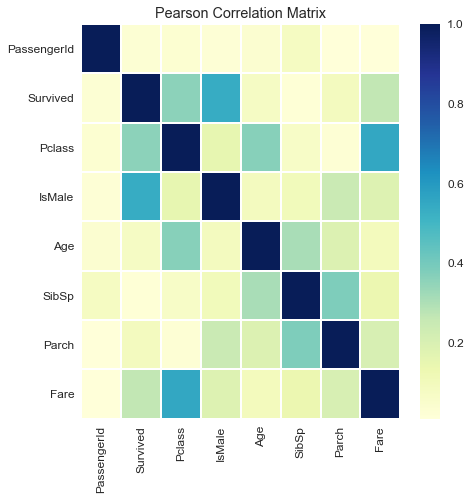

In [29]:
# draws pearson correlation matrix
# strongest correlations with 'Survived':
#   - Sex (isMale)
#   - Pclass
#   - Fare
plot_corrcoef()

In [30]:
# display top 5 strongest correlated features
# - strongest correlations between Survived and Sex, Pclass and Fare
print_top_correlations()

Top 5 correlations between 'Survived' and ...:
IsMale    0.538826
Pclass    0.359653
Fare      0.268189
Parch     0.093317
Age       0.077221
Name: Survived, dtype: float64



In [31]:
# check correlation between Fare and Pclass
# - Pclass and Fare are strongly correlated
print_top_correlations('Pclass')

Top 5 correlations between 'Pclass' and ...:
Fare        0.554182
Age         0.369226
Survived    0.359653
IsMale      0.155460
SibSp       0.067247
Name: Pclass, dtype: float64



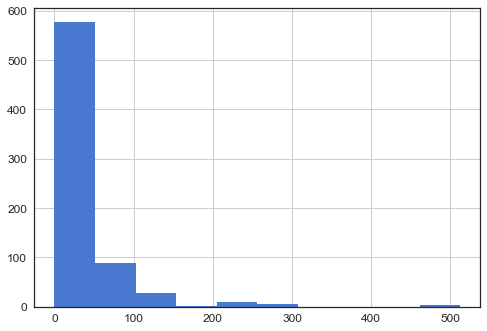

In [32]:
# draw histogram of fare
# - Fare contains extreme values
df['Fare'].hist()

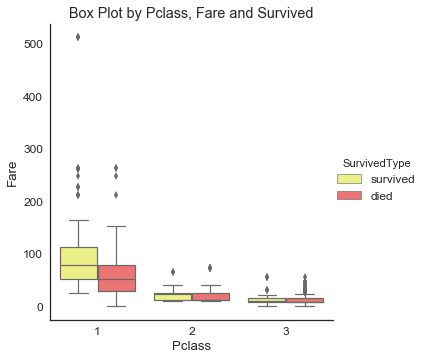

In [33]:
# draws boxplots of ticket classes and fares
# - higher classes have higher fare
# - in the same first class higher fare shows higher survival rate
plot_bivariate_continous('Pclass', 'Fare')

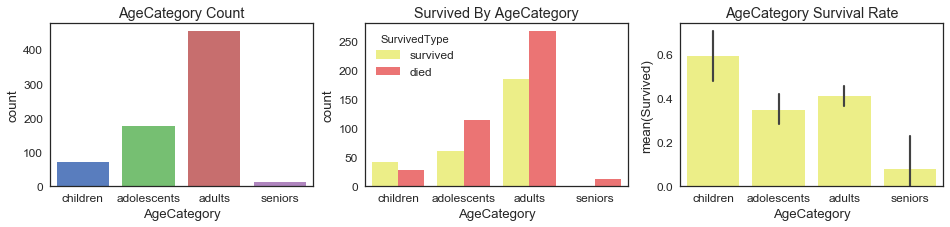

In [34]:
# check other features for non-linear correlations
# Age shows interesting survival rate between the different age groups:
#   - overproportionate survival rate for children
#   - seniors have less chance to survive
plot_univariate_analysis('AgeCategory', ['children', 'adolescents', 'adults', 'seniors'])

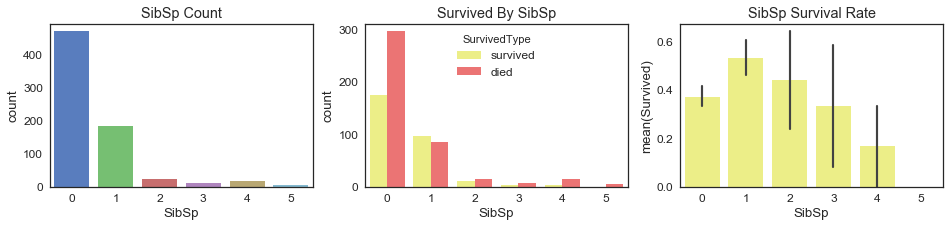

In [35]:
# Number of siblings / spouses aboard
#   - passengers with exactly 1 sibling or spouse have the greatest survival rate
#   - the survival rate falls with the number of siblings
plot_univariate_analysis('SibSp')

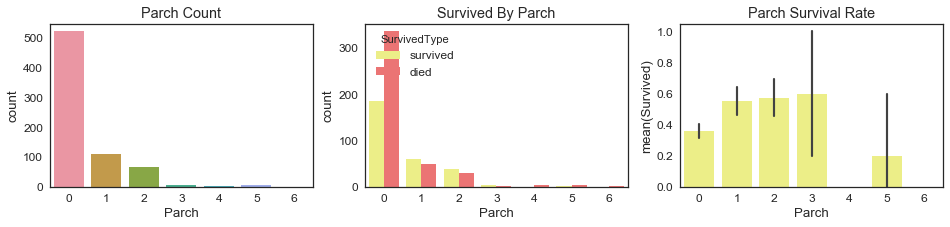

In [36]:
# Number of parents / children aboard
#   - passengers with 1 to 3 parents or children aboard have better chance to survive
#   - the survival rate falls when the number is above 3
plot_univariate_analysis('Parch')

**Question 2**: Were passengers in certain age groups more likely to survive?

Intuitively we would give children preference in rescue operations. And seniors were not strong enough or would give up early or would make way for the younger ones to the lifeboats. 

In the analysis we separated the passengers in [4 different age categories](http://www.statcan.gc.ca/eng/concepts/definitions/age2) by ranges of years:
* (0, 14]: children
* [15, 24]: adolescents
* [25, 64]: adults
* [65, \\(\infty\\)): seniors

**Observations and conclusions from the data analysis below**:
* The 'Age' is distributed unevenly.
    * Most passengers were adults between 25 and 35. 
    * The second largest group were children under 10.
* Pearson correlation with 'Survived': 
    * corr(Survived, Age)=0.077
    * no clear linear relationship between 'Survived' and 'Age'
* χ² test:
    * p-value=0.0003 < 0.001: 'Survived' and 'Age' are dependent in some way.
    * Cramér's V=.16: only a small effect size.
* Survival rates among the age categories:
    * children: 59.15%
    * adolescents: 34.66%
    * adults: 40.97%
    * seniors: 7.69%
* From the survival rates we can clearly recognize that younger passengers under 14 had more likely survived and the seniors with about 8% less likely.

**Limitations and future works**:
* The survival rate of seniors is subject to interpretation due to the small number of passengers in that group.
* Many entries were dropped due to missing values in 'Age'. Further analysis should show if this could have any effects on the results and conclusions we made in this report.
* Maybe we could use machine learning techniques to explain the possible non-linear relationship between 'Survived' and 'AgeCategory'.

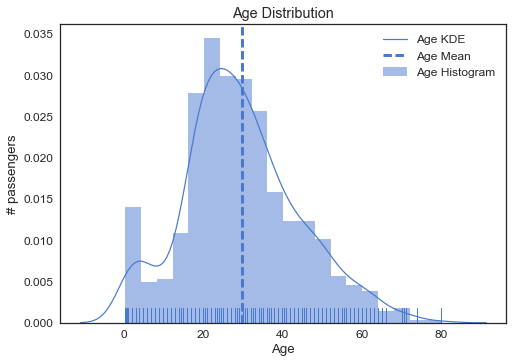

In [37]:
# draw histogram of Age
# - passengers are mainly adults between 25 and 35
# - many children under 10
plot_distribution('Age')

Descriptive statistics of 'AgeCategory':
count        714
unique         4
top       adults
freq         454
Name: AgeCategory, dtype: object

Relative frequencies of 'AgeCategory':
children       0.099440
adolescents    0.246499
adults         0.635854
seniors        0.018207
Name: AgeCategory, dtype: float64

Survival rate of 'AgeCategory':
AgeCategory
children       0.591549
adolescents    0.346591
adults         0.409692
seniors        0.076923
dtype: float64
'AgeCategory' and 'Survived' are dependent with 99.9% level of confidence:
- χ² statistic = 18.57
- p-value = 0.0003
- α threshold = 0.001
- df = 3
- Cramér's V = 0.16



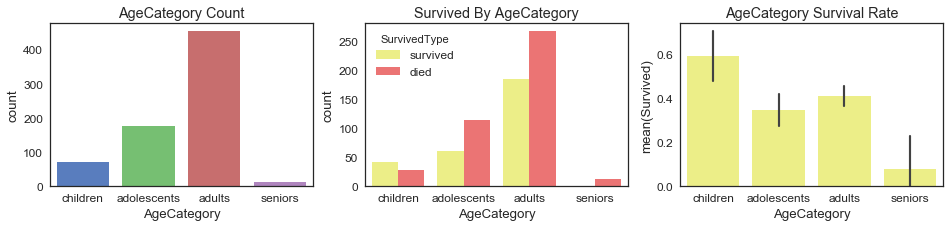

In [38]:
# print statistics and survival rates
analyze_feature('AgeCategory', ['children', 'adolescents', 'adults', 'seniors'])

**Question 3**: Did passengers with a higher socio-economic status have a greater chance to survive?

Intuitively passengers in a higher socio-economic class (identified by 'Pclass') would receive more attention by the crew and obtain better services thus easier chance to get into the lifeboats.

**Observations and conclusions from the data analysis below**:
* The most passengers were in the lower class (Pclass=3).
* The upper class had some more passengers than the middle class.
* Pearson correlation with 'Survived': 
    * corr(Survived, Pclass)=-.36
    * medium linear correlation between 'Survived' and 'Pclass'
    * the second strongest correlation after 'Sex'
* χ² test:
    * p-value=0.0000 < 0.001: 'Survived' and 'Pclass' are dependent somehow.
    * Cramér's V=.36: medium effect size
* Survival rates by 'Pclass':
    * upper class: 65.6%
    * middle class: 48.0%
    * lower class: 23.9%
* The upper class represented clearly the most of the survivors (over 65%). While only about 24% of the lower class passengers made their way to survive.


Descriptive statistics of 'Pclass':
count    714.000000
mean       2.236695
std        0.838250
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64

Relative frequencies of 'Pclass':
3    0.497199
1    0.260504
2    0.242297
Name: Pclass, dtype: float64

Survival rate of 'Pclass':
Pclass
1    0.655914
2    0.479769
3    0.239437
dtype: float64
Correlation between 'Pclass' and 'Survived': -0.36
'Pclass' and 'Survived' are dependent with 99.9% level of confidence:
- χ² statistic = 92.90
- p-value = 0.0000
- α threshold = 0.001
- df = 2
- Cramér's V = 0.36



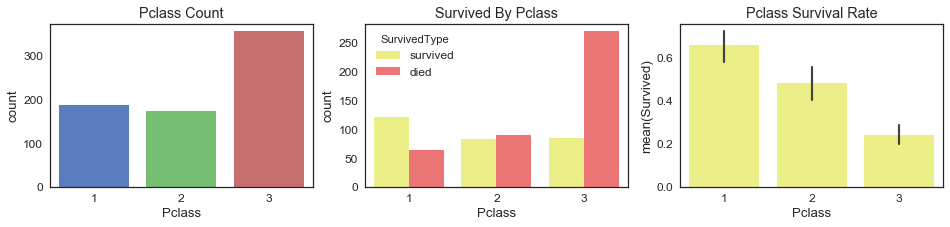

In [39]:
# print statistics and plot charts for Pclass
analyze_feature('Pclass')

**Question 4**: Did the passenger's sex have any effects on the survival rate? Could the effect observed among different classes or age groups?

Intuitively women like mothers with children, daughters with parents or girls with boy friends would be more likely given way into the lifeboats by men.

**Data analysis on 'Sex':**
* Most passengers were male. But among the survivers there were far more female passengers.
* Pearson correlation with 'Survived': 
    * corr(Survived, Sex)=-.54
    * strong pearson correlation between 'Survived' and 'Sex'
    * the strongest correlation among all features
* χ² test:
    * p-value=0.0000 < 0.001: 'Survived' and 'Sex' are dependent somehow.
    * Cramér's V=.54: large effect size
* Relative frequency distribution by 'Sex':
    * male: 63%
    * female: 37%
* Survival rates by 'Sex':
    * male: 21%
    * female: 76%


**Data analysis on combined factors: 'Sex' and 'Age':**
* From previous investigations we knew that children and women had higher survival rates. In this test we divide the passengers into four manually defined person classes and try to find even factors with higher survival chance.
* Self-defined person classes:
    * children under 14: 10% of all passengers
    * seniors above 65: about 2% of all passengers
    * male adults: about 56% were male adults
    * female adults: about 32% were female adults
* χ² test:
    * p-value=0.0000 < 0.001: 'Survived' and 'PersonClass' are dependent somehow.
    * Cramér's V=.57: large effect size    
* Survival rate by person class:
    * children: 59%
    * seniors: 8% (all seniors were male)
    * male adults: 18%
    * female adults: 78%
* Female adults had even a slightly better survival rate (78%) than female in the previous test (76%). The reason is that younger girls under 14 had a lower survival rate than female adults. Using 'Sex' and 'Age' these girls were excluded from the higher survival group.

**Data analysis on combined factors: 'Sex' and 'Pclass':**
* Most passengers were male and were in the lower class (identified by Pclass).
* In all socio-economic classes the majority of survivors were females.
* In the upper and middle classes more than 90% of females survived. But in the lower class only 46% of the female passengers survived.
* We analyzed the lower class by 'Sex' in more detail:
    * Survival rate in the lower class by sex:
        * male: 15%
        * female: 46%

**Data analysis on combined factors: 'Sex', 'Age' and 'Pclass':**
* The most passengers were male adults (between 14 and 65) and were in the lower class.
* The same observation could be observed in the lower class with the survival rates of children as of the female adults.
* In the upper class more than 75% of children survived. In the middle class even more children survived (~100%). But in the third class only 43% of the children could save their life from the disaster. 
* We analyzed passengers in the lower class and  by 'PersonClass' in detail:
    * Survival rate in the lower class by sex and age:
        * children: 43%
        * male adults: 13%
        * female adults: 45%
        * seniors: 0%
    * All sex and age groups in the third class had less chance to survive than the the upper or middle classes.

Descriptive statistics of 'Sex':
count      714
unique       2
top       male
freq       453
Name: Sex, dtype: object

Relative frequencies of 'Sex':
male      0.634454
female    0.365546
Name: Sex, dtype: float64

Survival rate of 'Sex':
Sex
male      0.205298
female    0.754789
dtype: float64
'Sex' and 'Survived' are dependent with 99.9% level of confidence:
- χ² statistic = 205.03
- p-value = 0.0000
- α threshold = 0.001
- df = 1
- Cramér's V = 0.54



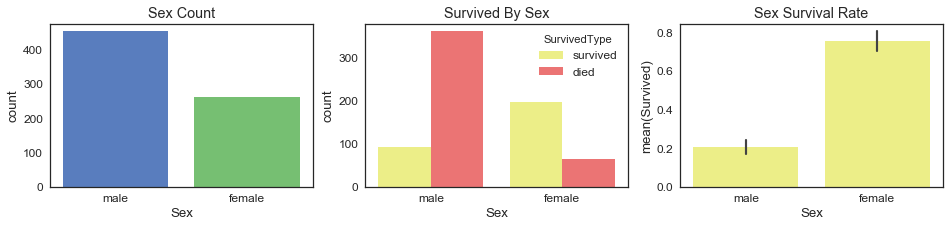

In [40]:
# print statistics and plot charts for Sex
analyze_feature('Sex', ['male', 'female'])

In [41]:
# use IsMale to calculate correlation and chi square test
print_feature_correlation('IsMale')

Correlation between 'IsMale' and 'Survived': -0.54
'IsMale' and 'Survived' are dependent with 99.9% level of confidence:
- χ² statistic = 205.03
- p-value = 0.0000
- α threshold = 0.001
- df = 1
- Cramér's V = 0.54



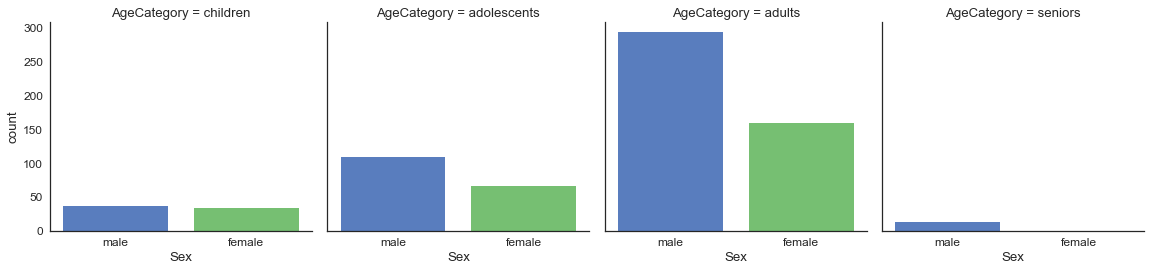

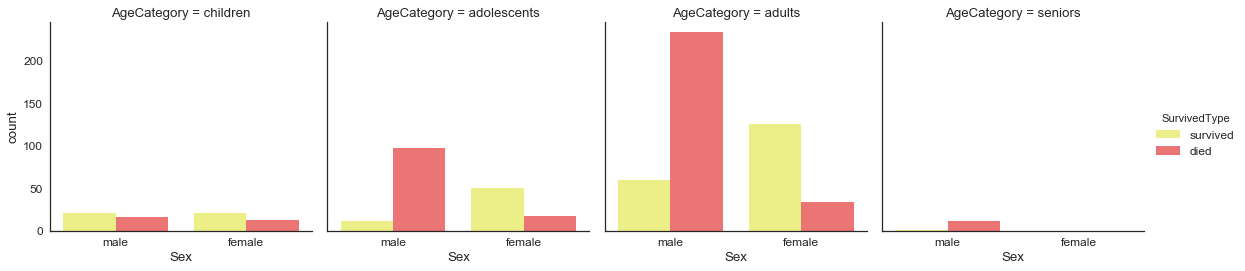

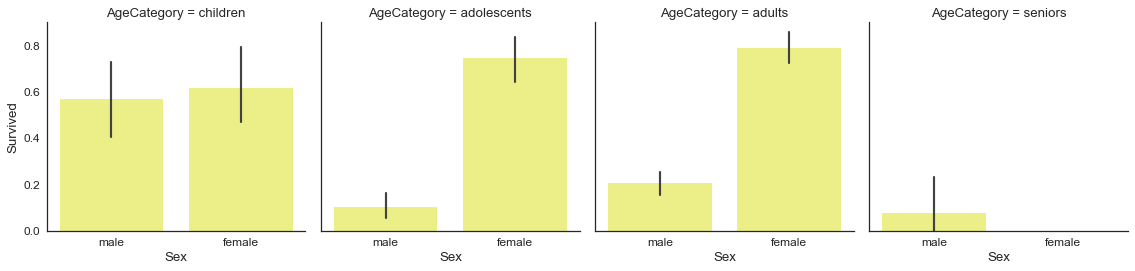

In [42]:
# draws count and survival plots by sex, person class and survived
plot_bivariate_categorical('Sex', 'AgeCategory', ['male', 'female'], ['children', 'adolescents', 'adults', 'seniors'])

Descriptive statistics of 'PersonClass':
count             714
unique              4
top       male adults
freq              403
Name: PersonClass, dtype: object

Relative frequencies of 'PersonClass':
children         0.099440
male adults      0.564426
female adults    0.317927
seniors          0.018207
Name: PersonClass, dtype: float64

Survival rate of 'PersonClass':
PersonClass
children         0.591549
male adults      0.176179
female adults    0.775330
seniors          0.076923
dtype: float64
'PersonClass' and 'Survived' are dependent with 99.9% level of confidence:
- χ² statistic = 232.60
- p-value = 0.0000
- α threshold = 0.001
- df = 3
- Cramér's V = 0.57



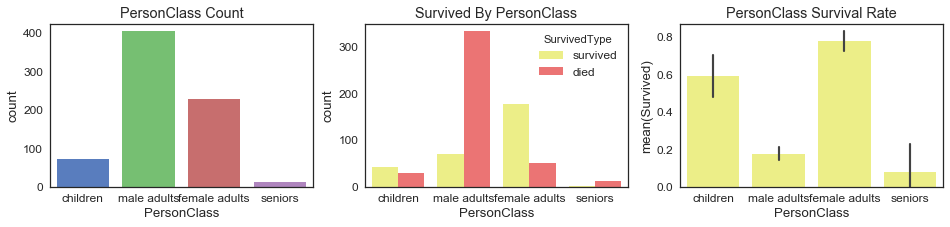

In [43]:
# print statistics and plot charts for PersonClass
analyze_feature('PersonClass', ['children', 'male adults', 'female adults', 'seniors'])

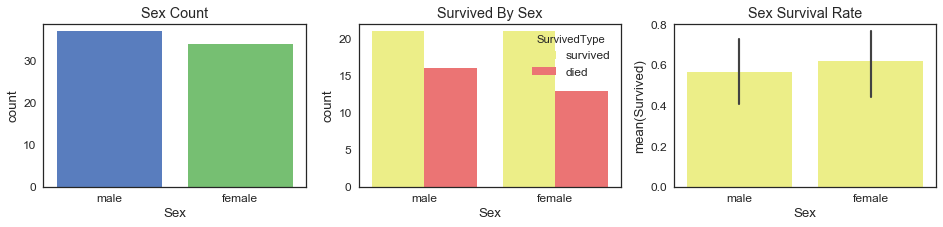

In [44]:
# print statistics and plot charts for Sex in the seniors group
# - boys and girls had almost the same survival rate
plot_univariate_analysis('Sex', ['male', 'female'], df[df['PersonClass'] == 'children'])

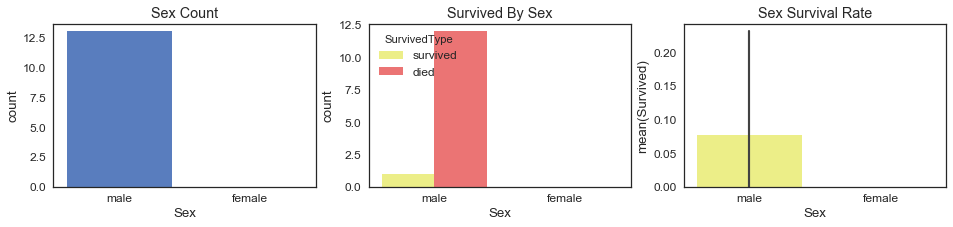

In [45]:
# print statistics and plot charts for Sex in the seniors group
# - no femaile seniors
plot_univariate_analysis('Sex', ['male', 'female'], df[df['PersonClass'] == 'seniors'])

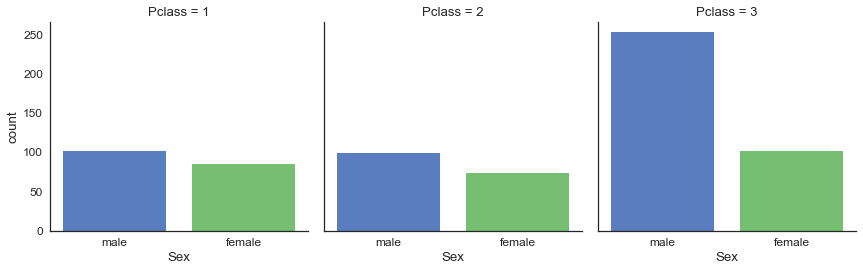

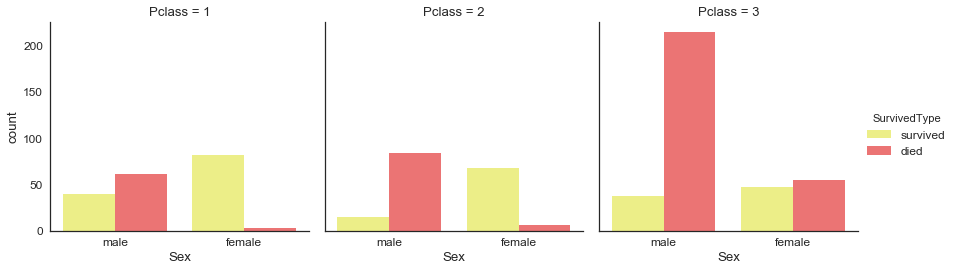

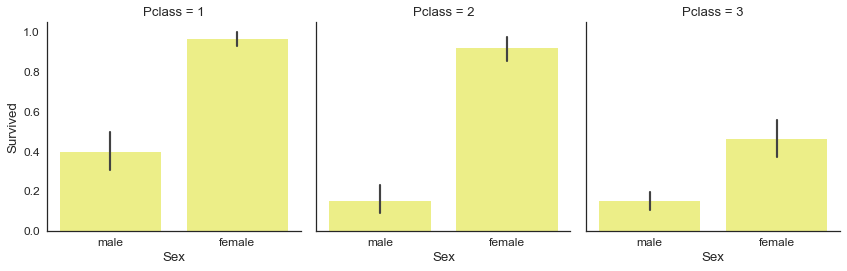

In [46]:
# print statistics and plot charts by sex and social class
# - big difference between the survival rate between the lower class and the other two social classes
plot_bivariate_categorical('Sex', 'Pclass', ['male', 'female'])

Descriptive statistics of 'Sex':
count      355
unique       2
top       male
freq       253
Name: Sex, dtype: object

Relative frequencies of 'Sex':
male      0.712676
female    0.287324
Name: Sex, dtype: float64

Survival rate of 'Sex':
Sex
male      0.150198
female    0.460784
dtype: float64
'Sex' and 'Survived' are dependent with 99.9% level of confidence:
- χ² statistic = 36.82
- p-value = 0.0000
- α threshold = 0.001
- df = 1
- Cramér's V = 0.32



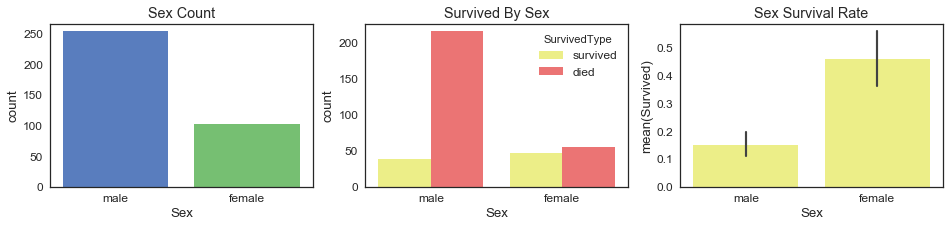

In [47]:
# analyze lower class passenger statistics and plot charts by Sex and Survived
# - females in the lower class have only a survival rate of 46% 
analyze_feature('Sex', ['male', 'female'], df[df['Pclass'] == 3])

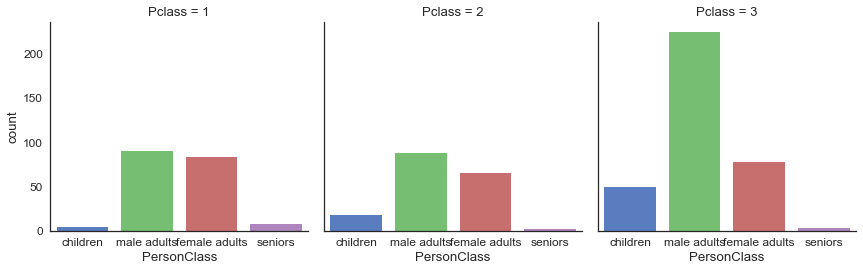

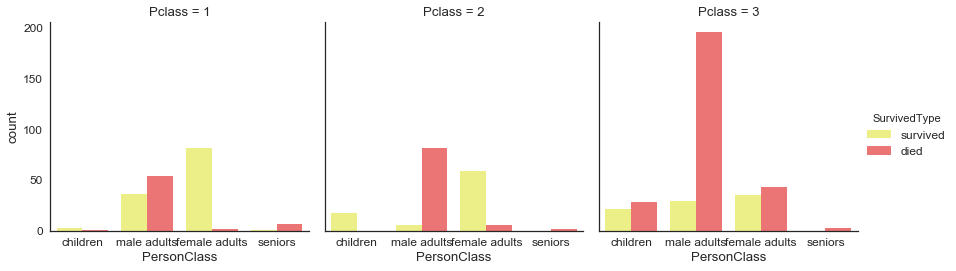

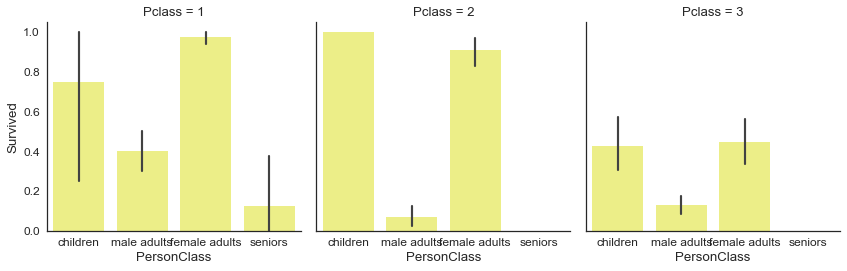

In [48]:
# draws count and survival plots by person class, social class and survived
# - children and women in the lower class have a survival rate below 50%
plot_bivariate_categorical('PersonClass', 'Pclass', ['children', 'male adults', 'female adults', 'seniors'])

Descriptive statistics of 'PersonClass':
count             355
unique              4
top       male adults
freq              225
Name: PersonClass, dtype: object

Relative frequencies of 'PersonClass':
children         0.138028
male adults      0.633803
female adults    0.219718
seniors          0.008451
Name: PersonClass, dtype: float64

Survival rate of 'PersonClass':
PersonClass
children         0.428571
male adults      0.128889
female adults    0.448718
seniors          0.000000
dtype: float64
'PersonClass' and 'Survived' are dependent with 99.9% level of confidence:
- χ² statistic = 44.43
- p-value = 0.0000
- α threshold = 0.001
- df = 3
- Cramér's V = 0.35



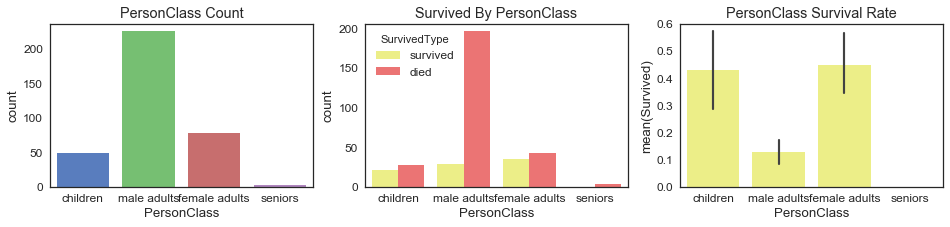

In [49]:
# analyze lower class passenger statistics and plot charts by Sex and Survived
# - children had only 43% chance to survive in the lower class
# - females had only 45% chance to survive in the lower class
analyze_feature('PersonClass', ['children', 'male adults', 'female adults', 'seniors'], df[df['Pclass'] == 3])

In [50]:
# print survival rates of adults and females by pclass
print_feature_statistics('Pclass', df = df[(df.AgeCategory == 'adults') & (df.IsMale == False)])

Descriptive statistics of 'Pclass':
count    160.000000
mean       1.875000
std        0.806811
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64

Relative frequencies of 'Pclass':
1    0.39375
2    0.33750
3    0.26875
Name: Pclass, dtype: float64

Survival rate of 'Pclass':
Pclass
1    0.968254
2    0.888889
3    0.395349
dtype: float64


### Conclusion

In this project we investigated the titanic data set using data analysis techniques such as descriptive statistics, pearson correlation matrix, chi-square test, cramér's V and various visualizations. 

We tried to answer the big question - what factors made people more likely to survive? Our answer: the features 'Sex', 'Pclass' and 'Age' had a great influence on the survival chance. E.g. as a woman between 25 and 64 with a first-class ticket you would have more than 97% chance to survive compared to the 38% overall survival rate.

For future analysis the following issues should be addressed:
* Not all of the "suspicious" findings in the exploration phase were analyzed in this report.
* In this report entries with missing data (e.g. Age, Cabin or Embarkation) were ignored from the analysis which may lead to some biased results and conclusions.
* Not all features and combinations were analyzed in this report. Few features such as fare, number of siblings or parents, port of embarkation, location of cabins etc. were not or only partially explored.
* Machine learning techniques could be used to create an appropriate model predicting the survival probabilitiy using historical data.
* Additional external information like religion, ethinicity, healthiness or cabin location of the passengers could be helpful to find out even more interesting relationships in the data.

## References

* [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/)
* [Seaborn documentation](http://seaborn.pydata.org/api.html)
* [Matplotlib documentation](http://matplotlib.org/index.html)
* [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/)
* [Kaggle: Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
* [Wikipedia: Chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test)
* [Wikipedia: Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r's_V)


## Reproduction Environment

In [51]:
import IPython
print IPython.sys_info()

{'commit_hash': u'5c9c918',
 'commit_source': 'installation',
 'default_encoding': 'cp936',
 'ipython_path': 'C:\\dev\\anaconda\\lib\\site-packages\\IPython',
 'ipython_version': '5.1.0',
 'os_name': 'nt',
 'platform': 'Windows-7-6.1.7601-SP1',
 'sys_executable': 'C:\\dev\\anaconda\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '2.7.13 |Anaconda custom (32-bit)| (default, Dec 19 2016, 13:36:02) [MSC v.1500 32 bit (Intel)]'}


In [52]:
!pip freeze

alabaster==0.7.9
anaconda-client==1.6.0
anaconda-navigator==1.4.3
argcomplete==1.0.0
astroid==1.4.9
astropy==1.3
Babel==2.3.4
backports-abc==0.5
backports.shutil-get-terminal-size==1.0.0
backports.ssl-match-hostname==3.4.0.2
beautifulsoup4==4.5.3
bitarray==0.8.1
blaze==0.10.1
bokeh==0.12.4
boto==2.45.0
Bottleneck==1.2.0
cdecimal==2.3
cffi==1.9.1
chardet==2.3.0
chest==0.2.3
click==6.7
cloudpickle==0.2.2
clyent==1.2.2
colorama==0.3.7
comtypes==1.1.2
conda==4.3.14
configobj==5.0.6
configparser==3.5.0
contextlib2==0.5.4
cryptography==1.7.1
cycler==0.10.0
Cython==0.25.2
cytoolz==0.8.2
dask==0.13.0
datashape==0.5.4
decorator==4.0.11
dill==0.2.5
docutils==0.13.1
enum34==1.1.6
et-xmlfile==1.0.1
fastcache==1.0.2
Flask==0.12
Flask-Cors==3.0.2
funcsigs==1.0.2
functools32==3.2.3.post2
futures==3.0.5
gevent==1.2.1
glueviz==0.9.1
greenlet==0.4.11
grin==1.2.1
h5py==2.6.0
HeapDict==1.0.0
idna==2.2
imagesize==0.7.1
ipaddress==1.0.18
ipykernel==4.5.2
ipython==5.1.0
ipython-genutils==0.1.0
ipywidgets==5.